In [1]:
# Activate your environment
import Pkg
Pkg.activate("../KellyEnv")

  Activating project at `c:\Users\Zahnbuerste_HQ\Documents\AA_Studium\Master\05_Masterarbeit\Playground\VS_refactor\KellyEnv`


In [2]:
using UnfoldSim
using Unfold
using StableRNGs
using SequentialSamplingModels
using CairoMakie, UnfoldMakie

In [3]:
include(joinpath(pathof(Unfold),"..","eventhandling.jl"))

copy_eventinfo!

In [4]:
using Statistics
function add_rt_to_events_and_slow_flag(evts)
    original_onsets = diff(evts.latency; dims=1)
    original_onsets = vcat(original_onsets, 600)
    evts.rt = original_onsets
    # Add slow_response flag
    mask = evts.event .== 'C'
    # Calculate the median only for the rows where the mask is true
    filtered_rt = evts.rt[mask]  
    med_rt = median(filtered_rt)
    # Initialize slow_response column with false
    evts.slow_response = falses(size(evts.rt))
    # Apply the condition only to the masked rows
    evts.slow_response[mask] .= filtered_rt .> med_rt
    return evts
end

add_rt_to_events_and_slow_flag (generic function with 1 method)

# Setup

In [5]:
fs = 500
Δt = 1/fs; # time step
tEnd = 1.0 # trial Duration
time_vec = 0:Δt:tEnd; # time base - let's make it a typical stimulus duration

design_single = SingleSubjectDesign(conditions = Dict(:drift_rate => [3, 5], :condition => [1]))
design_seq = SequenceDesign(design_single,"SCR_")
design_rep = RepeatDesign(design_seq,500)

RepeatDesign{SequenceDesign{SingleSubjectDesign}}
  design: SequenceDesign{SingleSubjectDesign}
  repeat: Int64 500


# Components

In [6]:
comp_length=0.7
stim = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(comp_length * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [0.8, 0],
)
resp = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(comp_length * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [0.5, 0],
)

kelly_model_parameter = Dict(:drift_rate => "drift_rate", :motor_onset => 0.4, :event_onset => 0.2)

drift = DriftComponent(fs,500,KellyModel,kelly_model_parameter)
components = Dict('S' => [stim], 'C' => [drift], 'R' => [resp])

Dict{Char, Vector} with 3 entries:
  'R' => LinearModelComponent[LinearModelComponent([0.0, 8.10284e-5, 0.00032408…
  'S' => LinearModelComponent[LinearModelComponent([0.0, 8.10284e-5, 0.00032408…
  'C' => DriftComponent[DriftComponent(500, 500, KellyModel, Dict{Symbol, Any}(…

# Onset

In [7]:
seq_onset = SequenceOnset(
    Dict('S'=>UniformOnset(width=40,offset=1.2*fs),
         'C'=>(DriftOnset(), UniformOnset(width=0, offset=-100)),
         'R'=>UniformOnset(width=100,offset=2*fs)))

SequenceOnset(Dict{Char, Any}('R' => UniformOnset
  width: Int64 100
  offset: Int64 1000
, 'S' => UniformOnset
  width: Int64 40
  offset: Float64 600.0
, 'C' => (DriftOnset{UniformOnset}(UniformOnset
  width: Int64 0
  offset: Int64 0
), UniformOnset
  width: Int64 0
  offset: Int64 -100
)))

# Simulation

In [17]:
data, evts = UnfoldSim.simulate(
    StableRNG(12),
    design_rep,
    components,
    seq_onset,
    NoNoise()#PinkNoise(noiselevel=1)#NoNoise() 
)
evts = add_rt_to_events_and_slow_flag(evts)

Row,drift_rate,condition,event,latency,rt,slow_response
,Int64,Int64,Char,Any,Int64,Bool
1,3,1,S,1099,612,false
2,3,1,C,1711,375,true
3,3,1,R,2086,1012,false
4,5,1,S,3098,612,false
5,5,1,C,3710,290,false
6,5,1,R,4000,1076,false
7,3,1,S,5076,608,false
8,3,1,C,5684,319,false
9,3,1,R,6003,1072,false


In [9]:
evts2  = deepcopy(evts)
evts2.trial_type = evts2.event
copy_eventinfo!(evts2,'C'=>'S',"slow_response";match_fun="s after t")
copy_eventinfo!(evts2,'C'=>'R',"slow_response";match_fun="s before t");

# Plots

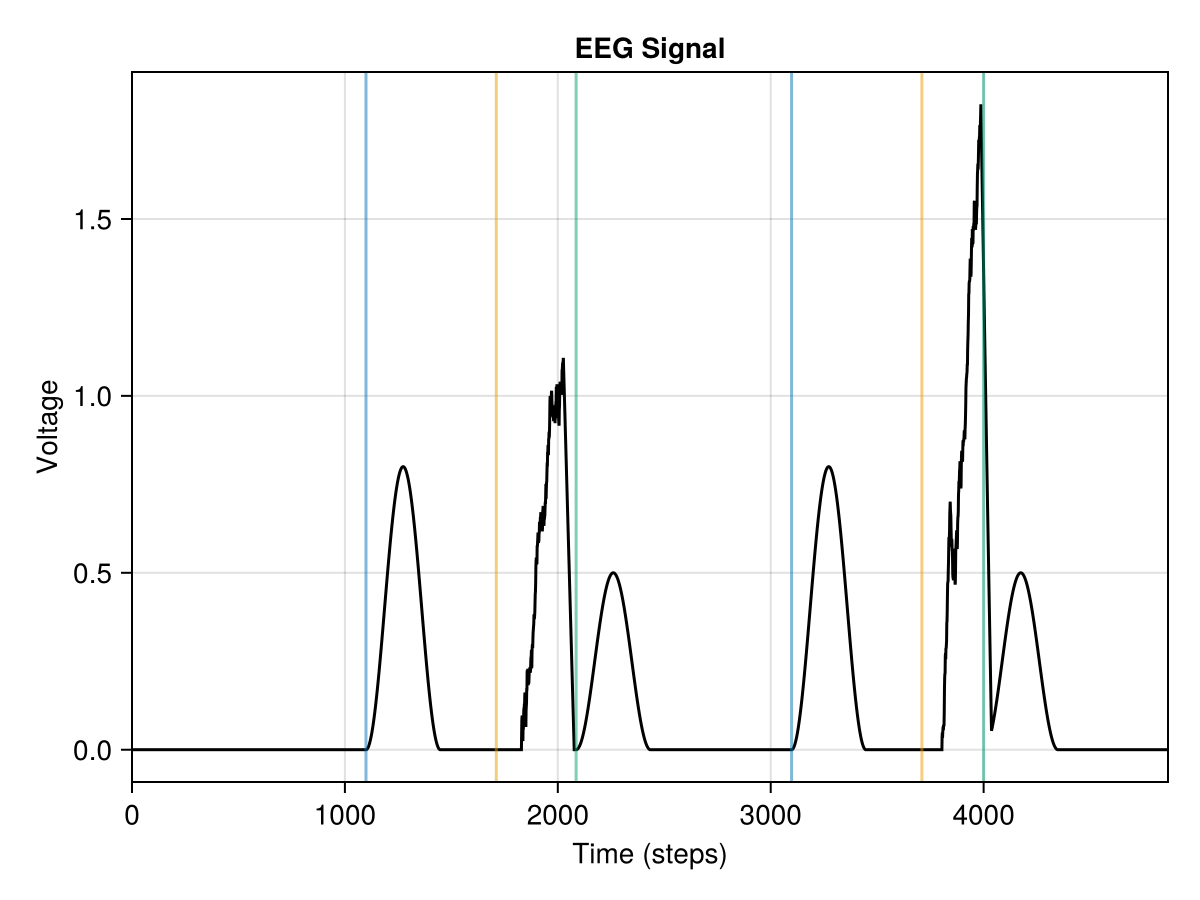

CairoMakie.Screen{IMAGE}


In [19]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Time (steps)", ylabel="Voltage", title="EEG Signal")
lines!(data[1:4866], color=(:black, 1))
evts_limited = deepcopy(evts)[1:6, :]
CairoMakie.xlims!(0, 4866)
vlines!(evts_limited.latency[evts_limited.event.=='S'], color = (Makie.wong_colors()[1], 0.5))
vlines!(evts_limited.latency[evts_limited.event.=='C'], color = (Makie.wong_colors()[2], 0.5))
vlines!(evts_limited.latency[evts_limited.event.=='R'], color = (Makie.wong_colors()[3], 0.5))
#current_figure()
# Display the plot
display(fig)

(isnothing(evts), isnothing(tbl)) = (false, false)


┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19


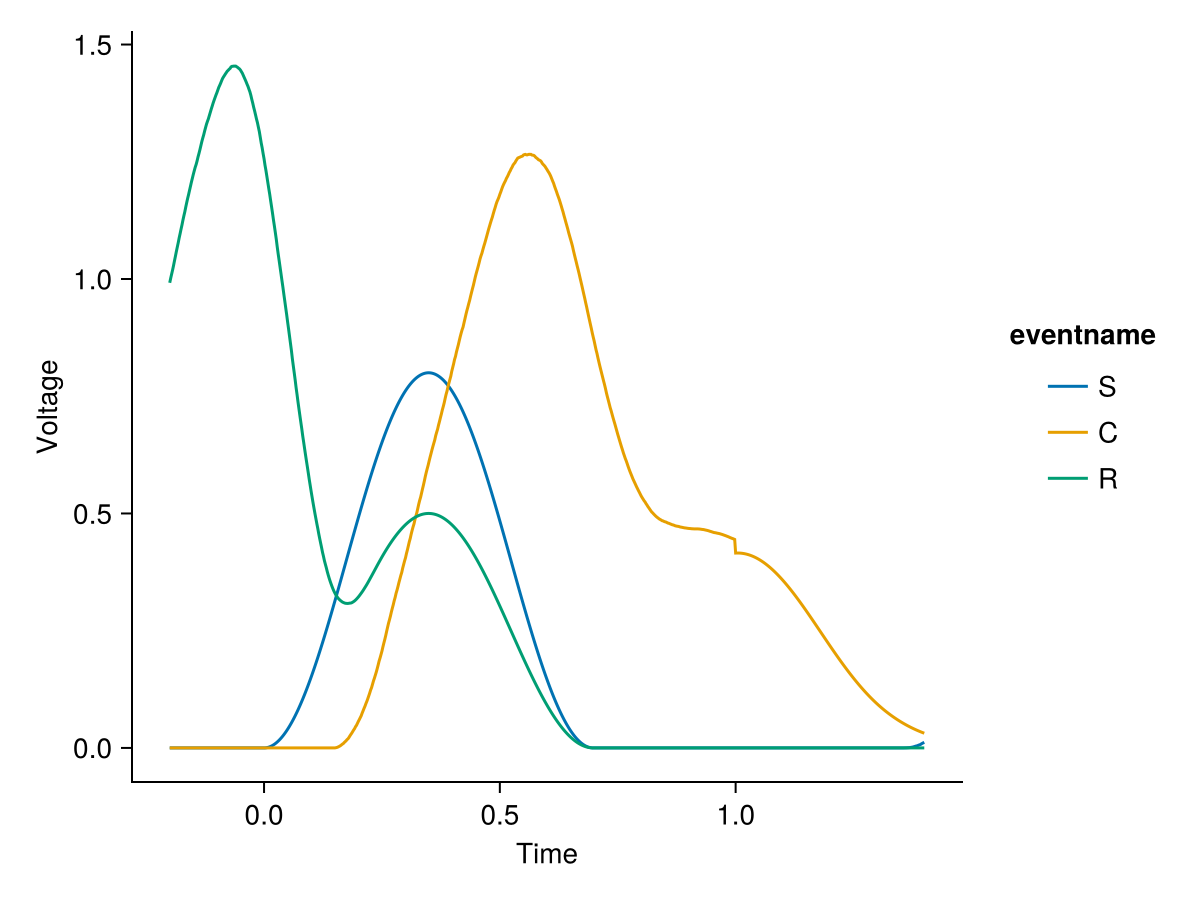

In [14]:
# ## Plot ERP of simulated EEG
evts.event = string.(evts.event)
data_epochs, times_epoch = Unfold.epoch(data = data, tbl = evts, τ = (-0.2, 1.4), sfreq = fs);
f = @formula(0 ~ 1)
m = fit(UnfoldModel, ["S"=>(f,times_epoch),"R"=>(f,times_epoch),"C"=>(f,times_epoch)], evts, data_epochs);
results = coeftable(m)
plot_erp(results;mapping=(;color=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter(["S","C","R"])))

In [28]:
# ## Deconvolution of the overlap
fir = firbasis(τ=(-0.4,1.2),sfreq=fs)
evts3 = deepcopy(evts)
evts3.event = string.(evts3.event)
m = fit(UnfoldModel, ["S"=>(f,fir),"R"=>(f,deepcopy(fir)),"C"=>(f,deepcopy(fir))], evts3, data);
results = coeftable(m)
plot_erp(results;mapping=(;color=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter(["S","C","R"])))

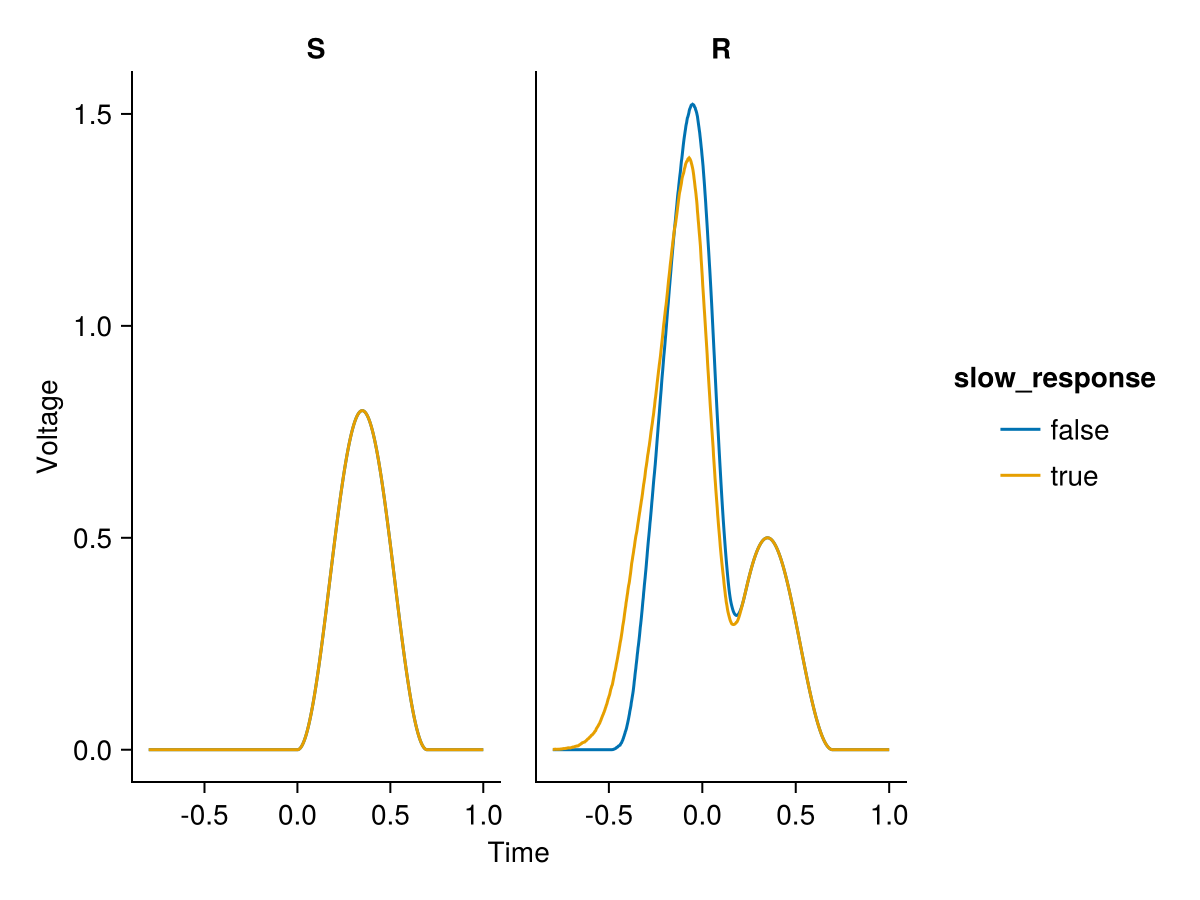

In [13]:
evts2.event = string.(evts2.event)
f = @formula 0 ~ 1 + slow_response
basisfunction = firbasis(τ=(-0.8,1.0),sfreq=fs; interpolate = false)
#m = fit(UnfoldModel, ["S"=>(f,times_epoch),"C"=>(f,times_epoch),"R"=>(f,times_epoch)], evts2, data_epochs);
m = fit(UnfoldModel, [
    "S"=>(f,basisfunction),
    "R"=>(f,deepcopy(basisfunction)),
    #"C"=>(f,deepcopy(basisfunction))
    ], evts2, data);
# Create effect
eff = effects(Dict(:slow_response => [false, true]), m)
# Plot Result
eff.slow_response = string.(eff.slow_response)
plot_erp(eff; mapping = (; color = :slow_response, col = :eventname => UnfoldMakie.AlgebraOfGraphics.sorter(["S","R"])))